# Imports

In [2]:
import pandas as pd
from pandas import Timestamp
import numpy as np
from operator import itemgetter
from datetime import datetime
import re

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
import contractions
import textcleaner as tc
import enchant
import pkg_resources
from symspellpy import SymSpell, Verbosity

# Load and Concat Both Datasets

In [2]:
'''Load the data sets from Google BigQuery (may have to be done in two parts as below).'''

df1 = pd.read_csv('/Users/francesco/bq-results-20200415-194253-dssl64rjnh0p.csv')
print(df1.shape)

df2 = pd.read_csv('/Users/francesco/bq-results-20200417-145909-6kc2o8yikdqz.csv')
print(df2.shape)

In [6]:
'''Concatenate the two dataframes into a single one.'''
df = pd.concat((df1, df2), ignore_index=True)
print(df.shape)

In [8]:
df.head()

,author,created_utc,title,selftext,subreddit,num_comments,score
0,CocoDeCongo,1483302020,"People who have lived with anxiety long term, ...","Hello, so, weird question, here I go explainin...",Anxiety,1,1
1,diazzle,1483334100,Arm/ body twitches,Whenever I am having/ about to have an anxiety...,Anxiety,2,2
2,OpheliaXavier,1483461581,Coping techniques?,I'm a freshman in high school. My boyfriend is...,Anxiety,1,3
3,anxiousthrowaway64,1483469503,At what point do you surrender to the anxiety ...,"So, I'm supposed to be going an 8 day long wor...",Anxiety,11,6
4,Pain_Austen,1483480485,Shower anxiety - any tips??,I have been having shower anxiety for the last...,Anxiety,0,2


# Initial Data Cleaning

In [9]:
df.subreddit.value_counts() # Initial look at distribution between classes.

depression      705139
SuicideWatch    287248
Anxiety         225530
bipolar         119483
Name: subreddit, dtype: int64

In [10]:
df.isnull().sum()

author              0
created_utc         0
title               6
selftext        73548
subreddit           0
num_comments        0
score               0
dtype: int64

In [11]:
df.dropna(inplace=True) # Drop NaNs.
df.shape

(1263846, 7)

In [13]:
print(df.duplicated().sum())
df.drop_duplicates(inplace=True) # Drop duplicates.

In [14]:
df.author.value_counts() # Lots of 'deleted' authors.

[deleted]             439669
sweetpea122              626
ThatWasNotEasy10         568
What_I_do_45             367
AutoModerator            305
                       ...  
theotakuorpgamer           1
CritzPT                    1
Raw_ZAGaming_YT            1
madisonwhite000999         1
ihsn-rmz                   1
Name: author, Length: 431703, dtype: int64

In [15]:
df = df[~(df.author == '[deleted]')] # Drop rows where 'author = deleted'.
df.shape

In [17]:
df = df[~(df.selftext == '[deleted]')] # Drop rows where 'selftext = deleted'.
df.shape

In [19]:
df = df[~(df.selftext == '[removed]')] # Drop rows where 'selftext = removed'.
df.shape

In [21]:
df.subreddit.value_counts()

depression      413490
SuicideWatch    159205
Anxiety         141082
bipolar          71876
Name: subreddit, dtype: int64

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 785653 entries, 0 to 1337023
Data columns (total 7 columns):
author          785653 non-null object
created_utc     785653 non-null int64
title           785653 non-null object
selftext        785653 non-null object
subreddit       785653 non-null object
num_comments    785653 non-null int64
score           785653 non-null int64
dtypes: int64(3), object(4)
memory usage: 48.0+ MB


In [23]:
df.author.value_counts() # Some authors have posted multiple times.

sweetpea122             625
ThatWasNotEasy10        566
What_I_do_45            359
AutoModerator           304
TheGutenbergMachine     255
                       ... 
endinsightthrowaway       1
girlnow                   1
5chwarzhund               1
hfmayo                    1
jdiehdbivjmftjsjfnsn      1
Name: author, Length: 417812, dtype: int64

In [27]:
df['date'] = converted_df = pd.to_datetime(df['created_utc'], unit='s') # Convert Unix time to readable format.

In [28]:
df.drop(['created_utc'], axis=1, inplace=True) # Drop unix time column. 
df.head()

,author,created_utc,title,selftext,subreddit,num_comments,score,date
0,CocoDeCongo,1483302020,"People who have lived with anxiety long term, ...","Hello, so, weird question, here I go explainin...",Anxiety,1,1,2017-01-01 20:20:20
1,diazzle,1483334100,Arm/ body twitches,Whenever I am having/ about to have an anxiety...,Anxiety,2,2,2017-01-02 05:15:00
2,OpheliaXavier,1483461581,Coping techniques?,I'm a freshman in high school. My boyfriend is...,Anxiety,1,3,2017-01-03 16:39:41
3,anxiousthrowaway64,1483469503,At what point do you surrender to the anxiety ...,"So, I'm supposed to be going an 8 day long wor...",Anxiety,11,6,2017-01-03 18:51:43
4,Pain_Austen,1483480485,Shower anxiety - any tips??,I have been having shower anxiety for the last...,Anxiety,0,2,2017-01-03 21:54:45


# Text Cleaning In Preperation For NLP

In [29]:
df.shape

(785653, 8)

In [32]:
df.head(3)

,author,created_utc,title,selftext,subreddit,num_comments,score,date
0,CocoDeCongo,1483302020,"People who have lived with anxiety long term, ...","Hello, so, weird question, here I go explainin...",Anxiety,1,1,2017-01-01 20:20:20
1,diazzle,1483334100,Arm/ body twitches,Whenever I am having/ about to have an anxiety...,Anxiety,2,2,2017-01-02 05:15:00
2,OpheliaXavier,1483461581,Coping techniques?,I'm a freshman in high school. My boyfriend is...,Anxiety,1,3,2017-01-03 16:39:41


In [34]:
df.dtypes

author                  object
created_utc              int64
title                   object
selftext                object
subreddit               object
num_comments             int64
score                    int64
date            datetime64[ns]
dtype: object

In [35]:
df['text'] = df['title'] + ' ' + df['selftext'] # Merge the title and selftext columns into a single one.
df.drop(['title', 'selftext'], axis=1, inplace=True)

In [36]:
df.head(3)

,author,created_utc,subreddit,num_comments,score,date,text
0,CocoDeCongo,1483302020,Anxiety,1,1,2017-01-01 20:20:20,"People who have lived with anxiety long term, ..."
1,diazzle,1483334100,Anxiety,2,2,2017-01-02 05:15:00,Arm/ body twitches Whenever I am having/ about...
2,OpheliaXavier,1483461581,Anxiety,1,3,2017-01-03 16:39:41,Coping techniques? I'm a freshman in high scho...


In [38]:
def replace_contractions(text):
    '''Replace words such as 'they're to they are' '''
    return contractions.fix(text)

def clean(text):
    '''Clean the text.'''
    try:
        cleaned_text = replace_contractions(text)
    except:
        print(text) 
        cleaned_text = None 
        pass
    
    cleaned_text = tc.document(cleaned_text).clear_blank_lines().strip_all().lower_all().remove_numbers()
    return cleaned_text.data

df.text = df.text.apply(lambda x: clean(x)) # Clean the text.

In [43]:
df.head()

,author,created_utc,subreddit,num_comments,score,date,text
0,CocoDeCongo,1483302020,Anxiety,1,1,2017-01-01 20:20:20,"[people who have lived with anxiety long term,..."
1,diazzle,1483334100,Anxiety,2,2,2017-01-02 05:15:00,[arm/ body twitches whenever i am having/ abou...
2,OpheliaXavier,1483461581,Anxiety,1,3,2017-01-03 16:39:41,[coping techniques? i am a freshman in high sc...
3,anxiousthrowaway64,1483469503,Anxiety,11,6,2017-01-03 18:51:43,[at what point do you surrender to the anxiety...
4,Pain_Austen,1483480485,Anxiety,0,2,2017-01-03 21:54:45,[shower anxiety - any tips?? i have been havin...


In [48]:
df.text = df.text.astype(str).str.replace('[_/.]', ' ') # Turn list into strings.
df.text = df.text.astype(str).str.replace('["\[\]?!:,\'\(\)\{\}]', '') # Remove symbols.

In [67]:
df.head()

,author,created_utc,subreddit,num_comments,score,date,text
0,CocoDeCongo,1483302020,Anxiety,1,1,2017-01-01 20:20:20,people who have lived with anxiety long term w...
1,diazzle,1483334100,Anxiety,2,2,2017-01-02 05:15:00,arm body twitches whenever i am having about...
2,OpheliaXavier,1483461581,Anxiety,1,3,2017-01-03 16:39:41,coping techniques i am a freshman in high scho...
3,anxiousthrowaway64,1483469503,Anxiety,11,6,2017-01-03 18:51:43,at what point do you surrender to the anxiety ...
4,Pain_Austen,1483480485,Anxiety,0,2,2017-01-03 21:54:45,shower anxiety - any tips i have been having s...


In [69]:
empties = df[df.text == ''].index # Some short text cells have had all words removed.
df.drop(empties, axis=0, inplace=True)

In [70]:
df.shape

(785653, 7)

In [74]:
df['word_count'] = df.text.map(lambda x: len(x.split())) # Add word counts for each row.

In [75]:
df.head()

,author,created_utc,subreddit,num_comments,score,date,text,word_count
0,CocoDeCongo,1483302020,Anxiety,1,1,2017-01-01 20:20:20,people who have lived with anxiety long term w...,157
1,diazzle,1483334100,Anxiety,2,2,2017-01-02 05:15:00,arm body twitches whenever i am having about...,28
2,OpheliaXavier,1483461581,Anxiety,1,3,2017-01-03 16:39:41,coping techniques i am a freshman in high scho...,183
3,anxiousthrowaway64,1483469503,Anxiety,11,6,2017-01-03 18:51:43,at what point do you surrender to the anxiety ...,270
4,Pain_Austen,1483480485,Anxiety,0,2,2017-01-03 21:54:45,shower anxiety - any tips i have been having s...,395
5,DoesNotRideShortBus,1483645720,Anxiety,6,4,2017-01-05 19:48:40,zoloft with weed and alcohol hey guys i finall...,184
6,joecoffeemug,1483693735,Anxiety,4,5,2017-01-06 09:08:55,intrusive thoughts panic attacks returning st...,189
7,indoor_person,1483943658,Anxiety,3,1,2017-01-09 06:34:18,created a semi-manageable life now have to s...,1448
8,SirPandaDrake,1483968925,Anxiety,0,1,2017-01-09 13:35:25,any help for nervous laughter smiling i am not...,92
9,ndftba,1484039600,Anxiety,9,6,2017-01-10 09:13:20,i just do not want to go hey there i just want...,207


In [76]:
df.to_csv('/Users/francesco/df', encoding='utf-8', index=False) # Export to use later.

# Spell Correct & Lemment

In [57]:
df = pd.read_csv('/Users/francesco/df') 

In [58]:
df.shape

(785646, 8)

In [60]:
df.head()

,author,created_utc,subreddit,num_comments,score,date,text,word_count
0,CocoDeCongo,1483302020,Anxiety,1,1,2017-01-01 20:20:20,people who have lived with anxiety long term w...,157
1,diazzle,1483334100,Anxiety,2,2,2017-01-02 05:15:00,arm body twitches whenever i am having about...,28
2,OpheliaXavier,1483461581,Anxiety,1,3,2017-01-03 16:39:41,coping techniques i am a freshman in high scho...,183
3,anxiousthrowaway64,1483469503,Anxiety,11,6,2017-01-03 18:51:43,at what point do you surrender to the anxiety ...,270
4,Pain_Austen,1483480485,Anxiety,0,2,2017-01-03 21:54:45,shower anxiety - any tips i have been having s...,395


In [66]:
stopwords = nltk.corpus.stopwords.words('english') # Add stop words after an initial look at the bag of words.
stopwords.extend(('wa', 'ha', 'doe', 
                 'depression', 'depressive', 
                 'anxiety', 'anxious', 'panic', 'attack',
                 'suicide', 'bipolar', 'manic'))

print(stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [373]:
def word_counter(mat):
    '''Count word appearances.'''
    count = np.array(mat.sum(axis=0))[0]
    return count

def word_frequency_sorter(words, counts):
    '''Sort words by frequency.'''
    sort_result = sorted(zip(words, list(counts)),
                         key=itemgetter(1), 
                         reverse=True)
    return sort_result

In [375]:
cvec = CountVectorizer(stop_words=stopwords) # Count vectorizer.

cvec.fit(df['text'])

cvec_mat_all = cvec.transform(df['text'])

words = cvec.get_feature_names()

In [384]:
d = enchant.Dict("en_US") # List of all the words in the US English dictionary. 

words_not_en = []
for word in words:
    '''Find words not in d'''
    if d.check(word) == False:        
        words_not_en.append(word)

In [385]:
len(words) - len(words_not_en) # 51614 words are English. 

51614

In [ ]:
len(words_not_en) # 200465 #51614 words are English. 

In [386]:
1 - (len(words_not_en) / len(words)) # Only 20% of words are english.

0.2047532717917796

In [388]:
words_not_en[0:10]

['aa',
 'aaa',
 'aaaa',
 'aaaaa',
 'aaaaaa',
 'aaaaaaa',
 'aaaaaaaa',
 'aaaaaaaaa',
 'aaaaaaaaaa',
 'aaaaaaaaaaa',
 'aaaaaaaaaaaa',
 'aaaaaaaaaaaaa',
 'aaaaaaaaaaaaaa',
 'aaaaaaaaaaaaaaa',
 'aaaaaaaaaaaaaaaa',
 'aaaaaaaaaaaaaaaaa',
 'aaaaaaaaaaaaaaaaaa',
 'aaaaaaaaaaaaaaaaaaa',
 'aaaaaaaaaaaaaaaaaaaa',
 'aaaaaaaaaaaaaaaaaaaaaa',
 'aaaaaaaaaaaaaaaaaaaaaaaa',
 'aaaaaaaaaaaaaaaaaaaaaaaaa',
 'aaaaaaaaaaaaaaaaaaaaaaaaaa',
 'aaaaaaaaaaaaaaaaaaaaaaaaaaa',
 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaa',
 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaa',
 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa',
 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa',
 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa',
 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa',
 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa',
 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa',
 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa',
 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa',
 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa',
 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa

In [389]:
'''SymSpell checks for words which are either misspelled, or two words without a space between them.'''

sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
dictionary_path = pkg_resources.resource_filename("symspellpy", 
                                                  "frequency_dictionary_en_82_765.txt"
                                                 )

bigram_path = pkg_resources.resource_filename("symspellpy", 
                                              "frequency_bigramdictionary_en_243_342.txt"
                                             )

sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
sym_spell.load_bigram_dictionary(bigram_path, term_index=0, count_index=2)

True

In [395]:
def spell_check(text):  
    '''Spell checking using SymSpell.'''
    suggestion = sym_spell.lookup_compound(text, max_edit_distance = 2)[0]
    return suggestion.term, suggestion.count

In [396]:
corrected_words = []

for word in words_not_en:
    '''Correct the words which can be corrected.'''
    corrected_words.append(spell_check(word))

In [398]:
len(corrected_words) # 200465 extra words can be added

200465

In [399]:
word_change_dict = dict(zip(words_not_en, [word[0] if word[1] != 0 else '' for word in corrected_words])) #Place the old and new words into a dictionary.

In [400]:
word_change_dict[0:10]

{'aa': 'a a',
 'aaa': 'a a',
 'aaaa': 'data',
 'aaaaa': 'alana',
 'aaaaaa': 'a data',
 'aaaaaaa': 'a alana',
 'aaaaaaaa': 'data data',
 'aaaaaaaaa': 'data alana',
 'aaaaaaaaaa': '',
 'aaaaaaaaaaa': '',
 'aaaaaaaaaaaa': '',
 'aaaaaaaaaaaaa': '',
 'aaaaaaaaaaaaaa': '',
 'aaaaaaaaaaaaaaa': '',
 'aaaaaaaaaaaaaaaa': '',
 'aaaaaaaaaaaaaaaaa': '',
 'aaaaaaaaaaaaaaaaaa': '',
 'aaaaaaaaaaaaaaaaaaa': '',
 'aaaaaaaaaaaaaaaaaaaa': '',
 'aaaaaaaaaaaaaaaaaaaaaa': '',
 'aaaaaaaaaaaaaaaaaaaaaaaa': '',
 'aaaaaaaaaaaaaaaaaaaaaaaaa': '',
 'aaaaaaaaaaaaaaaaaaaaaaaaaa': '',
 'aaaaaaaaaaaaaaaaaaaaaaaaaaa': '',
 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaa': '',
 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaa': '',
 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa': '',
 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa': '',
 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa': '',
 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa': '',
 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa': '',
 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa': '',
 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa': '',
 'aaaa

In [535]:
def spell_correct(text):
    '''Search the text column strings and replace words which are mispelled.'''
    string = ''
    for word in text.split():
        try:
            new_word =  word_change_dict[word]
            string = string + new_word + ' '

        except:
            new_word = word
            string = string + new_word + ' '
            
    return string

df.text = df.text.apply(lambda x: spell_correct(x))

In [538]:
df[df.text == ''] # Some strings are now empty.
df = df[~(df.text == '')]

,author,created_utc,subreddit,num_comments,score,date,text,word_count
21165,Twinkies4Dogs,1489926841,depression,30,51,2017-03-19 12:34:01,,0
105492,DaRandomBro,1532836662,depression,5,4,2018-07-29 03:57:42,,0
107128,BloodOfR3ptile,1529485851,SuicideWatch,17,16,2018-06-20 09:10:51,,0
172085,Foreverintherain,1519495143,depression,0,5,2018-02-24 17:59:03,,0
493720,Concernedogowner,1514254005,depression,1,6,2017-12-26 02:06:45,,0
695171,Wonderlustful,1429579786,depression,1,1,2015-04-21 01:29:46,,0
762053,IAmZelph,1439164698,bipolar,5,4,2015-08-09 23:58:18,,0


In [542]:
'''New count vectorizer.'''
cvec = CountVectorizer(stop_words=stopwords)

cvec.fit(df['text'])

cvec_mat_all = cvec.transform(df['text'])

words = cvec.get_feature_names()

In [544]:
csum_all = word_counter(cvec_mat_all)

In [545]:
words_frequency = pd.DataFrame(word_frequency_sorter(words, csum_all), columns=['word', 'frequency'])
words_frequency.set_index('word', inplace=True)
print(words_frequency)

              frequency
word                   
like            1059736
feel             902217
know             731419
want             694689
get              662665
...                 ...
우미스베이킹그녀의베이킹          1
탕종                    1
ｈｅｌｐ                  1
ｓａｄｂｏｉ                1
ﾟヮﾟ                   1

[80898 rows x 1 columns]


In [546]:
len(words) # 80898 words down from 200465

80898

In [547]:
d = enchant.Dict("en_US")

words_not_en = []

for word in words:
    if d.check(word) == False:        
        words_not_en.append(word)
    
print(1 - (len(words_not_en) / len(words))) # 65.4% of words are now English.

In [552]:
df.head()

,author,created_utc,subreddit,num_comments,score,date,text,word_count
0,CocoDeCongo,1483302020,Anxiety,1,1,2017-01-01 20:20:20,people who have lived with anxiety long term w...,157
1,diazzle,1483334100,Anxiety,2,2,2017-01-02 05:15:00,arm body twitches whenever i am having about t...,28
2,OpheliaXavier,1483461581,Anxiety,1,3,2017-01-03 16:39:41,coping techniques i am a freshman in high scho...,183
3,anxiousthrowaway64,1483469503,Anxiety,11,6,2017-01-03 18:51:43,at what point do you surrender to the anxiety ...,270
4,Pain_Austen,1483480485,Anxiety,0,2,2017-01-03 21:54:45,shower anxiety - any tips i have been having s...,395


In [585]:
lemmatizer = WordNetLemmatizer() 

def lemm(text):
    '''Lemment words in text column.'''
    return lemmatizer.lemmatize(text)

df.text = df.text.apply(lambda x: lemm(x))

In [587]:
df.to_csv('/Users/francesco/df2', encoding='utf-8', index=False) # Save csv file.

# Graphs

In [3]:
df = pd.read_csv('/Users/francesco/df2')

In [12]:
import matplotlib.style as style

style.available
style.use('seaborn-poster') #sets the size of the charts
style.use('ggplot')

In [165]:
df.subreddit.value_counts()

depression      413484
SuicideWatch    159198
Anxiety         141082
bipolar          71875
Name: subreddit, dtype: int64

In [170]:
counts = pd.DataFrame(df['subreddit'].value_counts(normalize=True))
counts

,subreddit
depression,0.526303
SuicideWatch,0.202635
Anxiety,0.179576
bipolar,0.091486


In [186]:
def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height() + 0.005
            value = '{:.2f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center", fontsize=18, color='orange') 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)


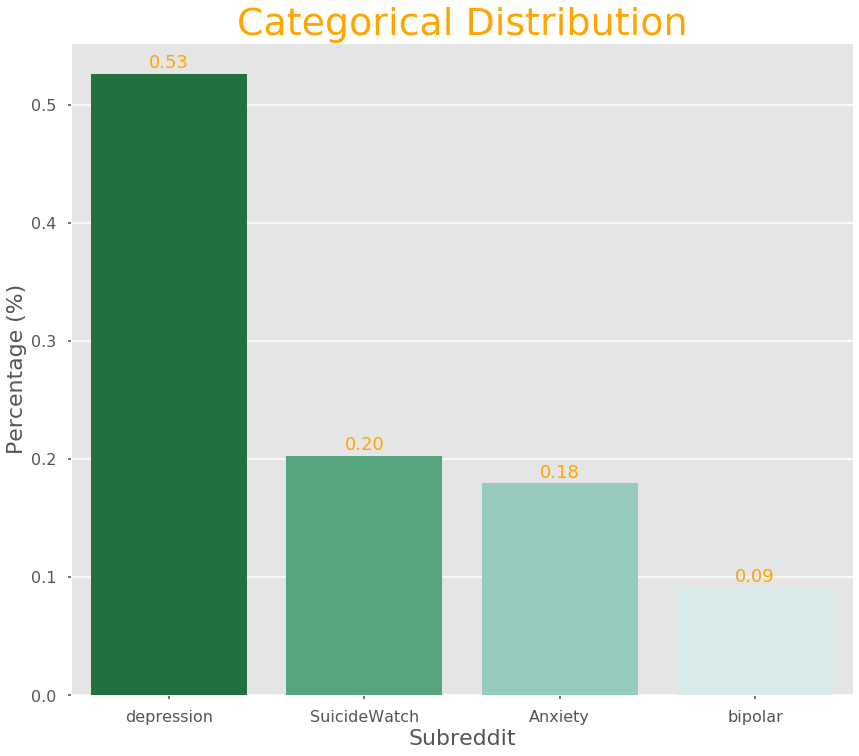

In [189]:
fig, ax = plt.subplots(figsize=(14, 12))
sns.barplot(data=counts, x=counts.index, y='subreddit', palette='BuGn_r');
plt.xlabel('Subreddit', fontsize=22)
plt.ylabel('Percentage (%)', fontsize=22)
plt.title('Categorical Distribution', fontsize=38, color='orange')
show_values_on_bars(ax)
plt.savefig("/Users/francesco/cat_counts_bar.png", transparent=True)

In [4]:
df.head()

,author,created_utc,subreddit,num_comments,score,date,text,word_count
0,CocoDeCongo,1483302020,Anxiety,1,1,2017-01-01 20:20:20,people who have lived with anxiety long term w...,157
1,diazzle,1483334100,Anxiety,2,2,2017-01-02 05:15:00,arm body twitches whenever i am having about t...,28
2,OpheliaXavier,1483461581,Anxiety,1,3,2017-01-03 16:39:41,coping techniques i am a freshman in high scho...,183
3,anxiousthrowaway64,1483469503,Anxiety,11,6,2017-01-03 18:51:43,at what point do you surrender to the anxiety ...,270
4,Pain_Austen,1483480485,Anxiety,0,2,2017-01-03 21:54:45,shower anxiety - any tips i have been having s...,395


In [19]:
counts = pd.DataFrame(df.subreddit.value_counts()/10000)
counts

,subreddit
depression,41.3484
SuicideWatch,15.9198
Anxiety,14.1082
bipolar,7.1875


In [9]:
plt.bar(df.subreddit.value_counts(), align='center')
plt.xticks(df.subreddit.value_counts(), list(pdf.subreddit.value_counts()));

TypeError: bar() missing 1 required positional argument: 'height'

In [4]:
word_counts = df.word_count.groupby(df['subreddit']).mean()

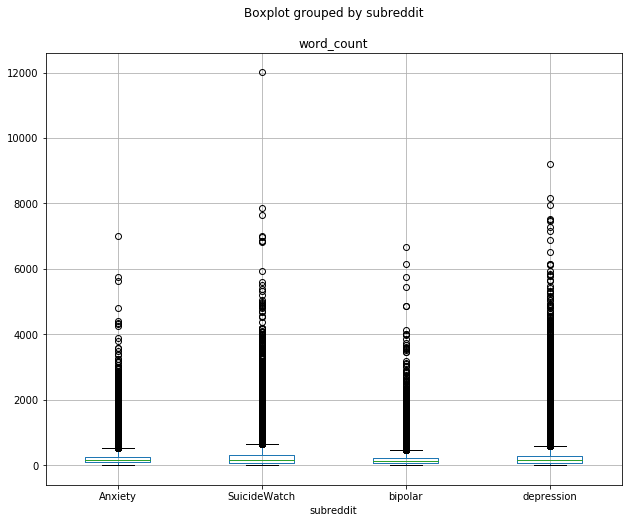

In [6]:
fig, ax = plt.subplots(figsize=(10,8))
plt.suptitle('')
df.boxplot(column=['word_count'], by='subreddit', ax=ax);

In [12]:
len(df.author[df.subreddit == 'depression'].unique())

236586

In [22]:
'''Average number of posts per author per subreddit.'''

post_per_auth = {'bipolar': df['subreddit'].value_counts()['bipolar'] / len(df.author[df.subreddit == 'bipolar'].unique()),
                'depression': df['subreddit'].value_counts()['depression'] / len(df.author[df.subreddit == 'depression'].unique()),
                'Anxiety': df['subreddit'].value_counts()['Anxiety'] / len(df.author[df.subreddit == 'Anxiety'].unique()),
                'SuicideWatch': df['subreddit'].value_counts()['SuicideWatch'] / len(df.author[df.subreddit == 'SuicideWatch'].unique())
                }

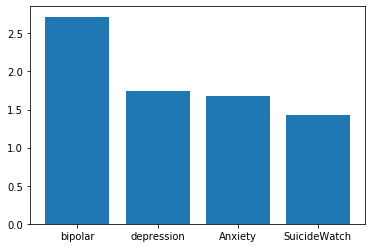

In [23]:
plt.bar(range(len(post_per_auth)), list(post_per_auth.values()), align='center')
plt.xticks(range(len(post_per_auth)), list(post_per_auth.keys()));

## Word Cloud (Count Vec)

In [48]:
'''Add stop words which are too obvious.'''

stopwords = nltk.corpus.stopwords.words('english')
stopwords.extend(('wa', 'ha', 'depression', 'depressive', 'depressed', 'anxiety', 'anxious', 
                  'panic', 'attack','suicide', 'bipolar', 'manic', 'mania', 'hypomania', 
                  'attacks', 'lithium','mg', 'die', 'kill', 'disorder', 'episode', 'episodes', 'polar', 'bi'))

print(stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [49]:
'''Count vectorize.'''
cvec = CountVectorizer(stop_words=stopwords)

cvec.fit(df['text'])

# Transform data from each of the subreddits.
cvec_mat_all = cvec.transform(df['text'])
cvec_mat_dep = cvec.transform(df.loc[df['subreddit'] == 'depression', 'text'])
cvec_mat_anx = cvec.transform(df.loc[df['subreddit'] == 'Anxiety', 'text'])
cvec_mat_sw = cvec.transform(df.loc[df['subreddit'] == 'SuicideWatch', 'text'])
cvec_mat_bip = cvec.transform(df.loc[df['subreddit'] == 'bipolar', 'text'])

words_c = cvec.get_feature_names()

In [50]:
def word_counter(mat):
    '''Count word appearances.'''
    count = np.array(mat.sum(axis=0))[0]
    return count

In [51]:
csum_all = word_counter(cvec_mat_all)
csum_dep = word_counter(cvec_mat_dep)
csum_anx = word_counter(cvec_mat_anx)
csum_sw = word_counter(cvec_mat_sw)
csum_bip = word_counter(cvec_mat_bip)

In [52]:
def word_frequency_sorter(words, counts):
    '''Sort the words by frequency.'''
    sort_result = sorted(zip(words, list(counts)),
                         key=itemgetter(1), reverse=True)
    return sort_result

In [53]:
def word_freq_hist(df_word_frequency):
    '''Plot word frequency histogram.'''
    df_word_frequency.plot(kind='hist',
                       bins=np.logspace(1, 3, 50),
                       loglog=True,
                       title='Number of words with a given number of appearances',
                       fontsize=14)
    plt.show()

In [54]:
'''Take the highest count words.'''
d_all_c = {}
for a, x in pd.DataFrame(word_frequency_sorter(words_c, csum_all), columns=['word', 'frequency']).values:
    d_all_c[a] = x
    
d_dep_c = {}
for a, x in pd.DataFrame(word_frequency_sorter(words_c, csum_dep), columns=['word', 'frequency']).values:
    d_dep_c[a] = x
    
d_anx_c = {}
for a, x in pd.DataFrame(word_frequency_sorter(words_c, csum_anx), columns=['word', 'frequency']).values:
    d_anx_c[a] = x
    
d_bip_c = {}
for a, x in pd.DataFrame(word_frequency_sorter(words_c, csum_bip), columns=['word', 'frequency']).values:
    d_bip_c[a] = x
    
d_sw_c = {}
for a, x in pd.DataFrame(word_frequency_sorter(words_c, csum_sw), columns=['word', 'frequency']).values:
    d_sw_c[a] = x

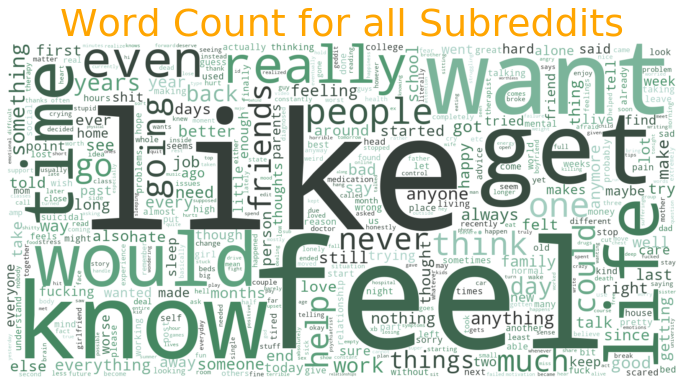

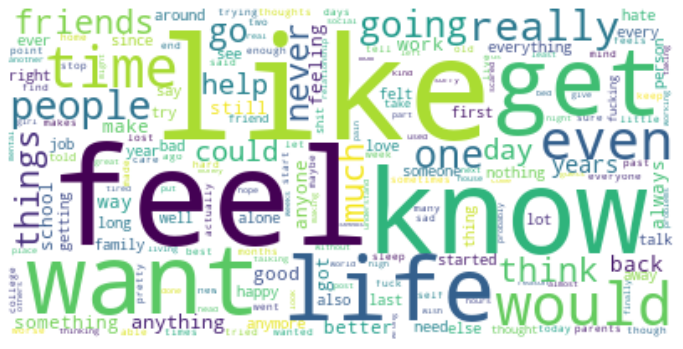

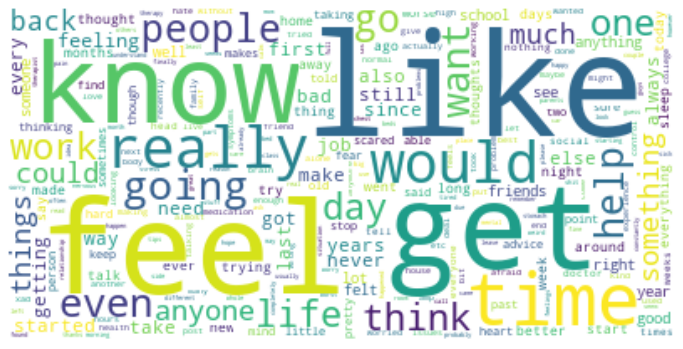

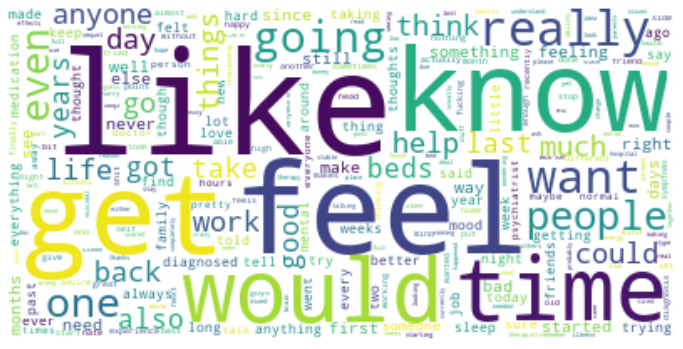

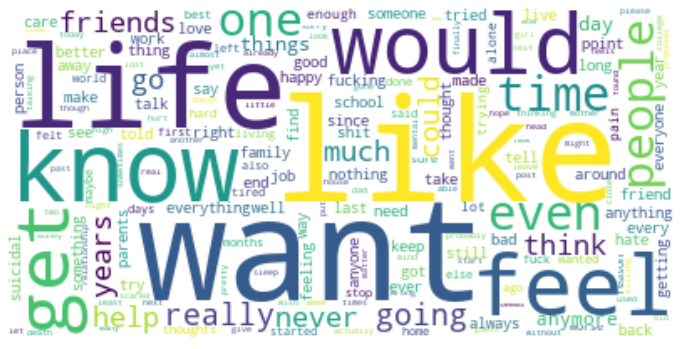

In [161]:
'''Plot the word clouds for all words, and those in each subreddit.'''
wordcloud_all_c = WordCloud(background_color="white", max_words=500, width=1600, height=800, colormap=cmap).generate_from_frequencies(d_all_c)
plt.figure(figsize=(12, 12))
plt.imshow(wordcloud_all_c, interpolation="bilinear")
plt.axis("off")
plt.title('Word Count for all Subreddits', fontsize=38, color='orange')
plt.savefig("/Users/francesco/cvec_all.png", transparent=True, dpi=1000)
plt.show()

wordcloud_dep_c = WordCloud(background_color="white", max_words=1000).generate_from_frequencies(d_dep_c)
plt.figure(figsize=(12, 12))
plt.imshow(wordcloud_dep_c, interpolation="bilinear")
plt.axis("off")
plt.show()

wordcloud_anx_c = WordCloud(background_color="white", max_words=1000).generate_from_frequencies(d_anx_c)
plt.figure(figsize=(12, 12))
plt.imshow(wordcloud_anx_c, interpolation="bilinear")
plt.axis("off")
plt.show()

wordcloud_bip_c = WordCloud(background_color="white", max_words=1000).generate_from_frequencies(d_bip_c)
plt.figure(figsize=(12, 12))
plt.imshow(wordcloud_bip_c, interpolation="bilinear")
plt.axis("off")
plt.show()

wordcloud_sw_c = WordCloud(background_color="white", max_words=1000).generate_from_frequencies(d_sw_c)
plt.figure(figsize=(12, 12))
plt.imshow(wordcloud_sw_c, interpolation="bilinear")
plt.axis("off")
plt.show()


## Word Cloud (TFIDF)

In [56]:
'''TFDIF - word clouds shows most important words compared to each other category.'''

tvec = TfidfVectorizer(stop_words=stopwords, norm='l2')

tvec.fit(df.text)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...],
                strip_accents=None, sublinear_tf=False,
                token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
                vocabulary=None)

In [57]:
tvec_mat_all = tvec.transform(df['text'])
tvec_mat_dep = tvec.transform(df.loc[df['subreddit'] == 'depression', 'text'])
tvec_mat_anx = tvec.transform(df.loc[df['subreddit'] == 'Anxiety', 'text'])
tvec_mat_sw = tvec.transform(df.loc[df['subreddit'] == 'SuicideWatch', 'text'])
tvec_mat_bip = tvec.transform(df.loc[df['subreddit'] == 'bipolar', 'text'])

In [58]:
# words occuring
words_t = tvec.get_feature_names()

tsum_all = word_counter(tvec_mat_all)
tsum_dep = word_counter(tvec_mat_dep)
tsum_anx = word_counter(tvec_mat_anx)
tsum_sw = word_counter(tvec_mat_sw)
tsum_bip = word_counter(tvec_mat_bip)

In [59]:
tsums = [tsum_all, tsum_dep, tsum_anx, tsum_sw, tsum_bip]

for i in tsums:
    df_t_word_frequency = pd.DataFrame(word_frequency_sorter(words_t, i), columns=['word', 'frequency'])
    df_t_word_frequency.set_index('word', inplace=True)
    
    print(df_t_word_frequency.head(15))
    print('\n')
    

           frequency
word                
like    32268.535785
feel    31466.349762
want    27329.075253
know    25411.710592
get     22776.732952
life    22660.167836
would   21342.742959
really  20515.188211
time    19705.465606
people  19391.060077
even    18717.582522
going   17727.088561
one     16991.508328
help    16947.412078
think   16039.985482


            frequency
word                 
feel     19082.563622
like     18590.450717
want     15164.314168
know     14178.203365
life     13201.277946
get      12350.685675
people   11407.819672
would    11378.267989
really   11309.926525
time     10940.535401
even     10897.637481
friends   9636.277390
one       9409.956908
going     8883.909399
help      8796.420739


          frequency
word               
like    5473.811372
feel    4818.858163
get     4412.160727
know    3699.014563
really  3672.619650
time    3345.676180
anyone  3308.826669
going   3217.030664
help    3190.892637
would   3054.939020
go      2800.573659
work 

In [95]:
d_all_t = {}
for a, x in pd.DataFrame(word_frequency_sorter(words_t, tsum_all), columns=['word', 'frequency']).values:
    d_all_t[a] = x
    
d_dep_t = {}
for a, x in pd.DataFrame(word_frequency_sorter(words_t, tsum_dep), columns=['word', 'frequency']).values[10:]:
    d_dep_t[a] = x
    
d_anx_t = {}
for a, x in pd.DataFrame(word_frequency_sorter(words_t, tsum_anx), columns=['word', 'frequency']).values[10:]:
    d_anx_t[a] = x
    
d_bip_t = {}
for a, x in pd.DataFrame(word_frequency_sorter(words_t, tsum_bip), columns=['word', 'frequency']).values[10:]:
    d_bip_t[a] = x
    
d_sw_t = {}
for a, x in pd.DataFrame(word_frequency_sorter(words_t, tsum_sw), columns=['word', 'frequency']).values[10:]:
    d_sw_t[a] = x

In [98]:
from PIL import Image
brain_mask = np.array(Image.open( "/Users/francesco/brain.jpg"))

In [156]:
cmap = sns.choose_colorbrewer_palette('sequential', as_cmap=True)

interactive(children=(Dropdown(description='name', options=('Greys', 'Reds', 'Greens', 'Blues', 'Oranges', 'Pu…

In [157]:
cmap

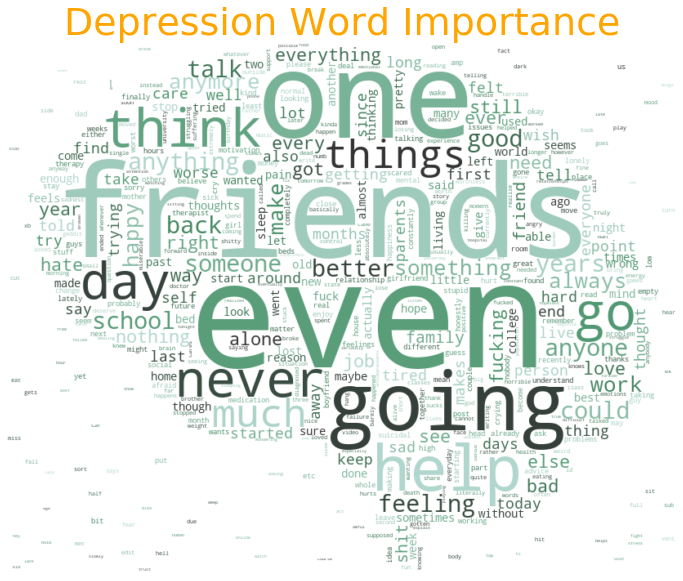

In [164]:
# wordcloud_all_t = WordCloud(background_color="white", max_words=500, width=1600, height=800, colormap=cmap, mask=brain_mask).generate_from_frequencies(d_all_t)
# plt.figure(figsize=(12, 12))
# plt.imshow(wordcloud_all_t, interpolation="bilinear")
# plt.axis("off")
# plt.show()

wordcloud_dep_t = WordCloud(background_color="white", max_words=500, width=1600, height=800, colormap=cmap, mask=brain_mask).generate_from_frequencies(d_dep_t)
plt.figure(figsize=(12, 12))
plt.imshow(wordcloud_dep_t, interpolation="bilinear")
plt.axis("off")
plt.title('Depression Word Importance', fontsize=38, color='orange')
plt.savefig("/Users/francesco/tvec_dep.png", transparent=True, dpi=1000)
plt.show()

# wordcloud_anx_t = WordCloud(background_color="white", max_words=500, width=1600, height=800, colormap="BuGn", mask=brain_mask).generate_from_frequencies(d_anx_t)
# plt.figure(figsize=(12, 12))
# plt.imshow(wordcloud_anx_t, interpolation="bilinear")
# plt.axis("off")
# plt.title('Anxiety Word Importance', fontsize=38, color='orange')
# plt.savefig("/Users/francesco/tvec_anx.png", transparent=True, dpi=1000)
# plt.show()

# wordcloud_bip_t = WordCloud(background_color="white", max_words=500, width=1600, height=800, colormap="BuGn", mask=brain_mask).generate_from_frequencies(d_bip_t)
# plt.figure(figsize=(12, 12))
# plt.imshow(wordcloud_bip_t, interpolation="bilinear")
# plt.axis("off")
# plt.title('Bipolar Word Importance', fontsize=38, color='orange')
# plt.savefig("/Users/francesco/tvec_bip.png", transparent=True, dpi=1000)
# plt.show()

# wordcloud_sw_t = WordCloud(background_color="white", max_words=500, width=1600, height=800, colormap="BuGn", mask=brain_mask).generate_from_frequencies(d_sw_t)
# plt.figure(figsize=(12, 12))
# plt.imshow(wordcloud_sw_t, interpolation="bilinear")
# plt.axis("off")
# plt.title('Suicide Word Importance', fontsize=38, color='orange')
# plt.savefig("/Users/francesco/tvec_sw.png", transparent=True, dpi=1000)
# plt.show()


cmap